## Modélisation

In [1]:
# Manipulation
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Normalisation
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métriques d'évaluation
from sklearn.metrics import (
    classification_report,  # Rapport de classification
    confusion_matrix,  # Matrice de confusion
    roc_auc_score,  # Score AUC-ROC
    roc_curve,  # Courbe ROC
    precision_score,  # Score de précision
    brier_score_loss,  # Score de calibration Brier
    f1_score  # Score F1
)

# Calibrage de modèle
from sklearn.calibration import calibration_curve

# Gestion des fichiers et des répertoires
import os


In [2]:
# Définition du chemin du fichier de données prétraitées
file_path = os.path.join("..", "data", "cs-training_preprocessed.csv")
data = pd.read_csv(file_path)

In [3]:
# if "age_cat" in data.columns:
#     data = data.drop(columns=["age_cat"])

In [4]:
# Sélection des colonnes explicatives (features)
Colonnes_Utilisées = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

# Définition de la colonne cible (label)
Colonne_Prédiction = 'SeriousDlqin2yrs'

In [5]:
# Standardisation des features
scaler = StandardScaler()
X = scaler.fit_transform(data[Colonnes_Utilisées])
y = data[Colonne_Prédiction].values.ravel()


Les données sont désesquilibrer comme il est important de faire un équilibrage manuel du jeu de données pour garantir une répartition homogène entre les classes. Sinon, ce désesquilibre entre classes pourrait biaiser l'apprentissage de nos modèles.

In [6]:
# Séparation des indices des classes positives (1) et négatives (0)
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

In [7]:
# Mélange des indices pour garantir une répartition aléatoire
np.random.seed(42)
np.random.shuffle(class_0_indices)
np.random.shuffle(class_1_indices)

In [8]:
# Définition du ratio de test (20% des données)
test_ratio = 0.2
num_test_class_0 = int(len(class_0_indices) * test_ratio)
num_test_class_1 = int(len(class_1_indices) * test_ratio)

In [9]:
# Séparation des indices en ensembles d'entraînement et de test
test_indices = np.concatenate((class_0_indices[:num_test_class_0], class_1_indices[:num_test_class_1]))
train_indices = np.concatenate((class_0_indices[num_test_class_0:], class_1_indices[num_test_class_1:]))

In [10]:
# Création des jeux de données d'entraînement et de test
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [11]:
print("Proportions dans y_train:", np.bincount(y_train) / len(y_train))
print("Proportions dans y_test:", np.bincount(y_test) / len(y_test))

Proportions dans y_train: [0.93315889 0.06684111]
Proportions dans y_test: [0.93316444 0.06683556]


Passons à la modélisation.

#### Régression Logistique

In [12]:
# Modèle de Régression Logistique
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Prédictions et probabilités
y_proba_log = log_reg_model.predict_proba(X_test)[:, 1]
y_pred_log = (y_proba_log >= 0.5).astype(int)

In [13]:
# Calcul des métriques
auc_log = roc_auc_score(y_test, y_proba_log)
prec_log = precision_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
brier_log = brier_score_loss(y_test, y_proba_log)

# Afficher les métriques
print("\nRégression Logistique :")
print(f"AUC : {auc_log:.3f}")
print(f"Précision : {prec_log:.3f}")
print(f"F1 Score : {f1_log:.3f}")
print(f"Brier Score : {brier_log:.3f}")


Régression Logistique :
AUC : 0.844
Précision : 0.220
F1 Score : 0.335
Brier Score : 0.146


Le coefficient de Gini est pertinent pour prédire le risque de crédit car il mesure la capacité d'un modèle à distinguer efficacement les bons payeurs des mauvais, tout en prenant en compte les déséquilibres dans les données. Il est calculé à partir de la formule suivante :

$\text{Gini} = \frac{2 \times (\text{AUC} - 0.5)}{1 - d}$

où \( d \) représente le taux de défaut moyen.

In [14]:
default_rate = sum(y_test) / len(y_test)
gini = (2 * (auc_log - 0.5)) / (1 - default_rate)

print(f"Gini :{gini}")

Gini :0.7374263526476014


In [15]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89     27994
           1       0.22      0.70      0.33      2005

    accuracy                           0.81     29999
   macro avg       0.60      0.76      0.61     29999
weighted avg       0.92      0.81      0.85     29999



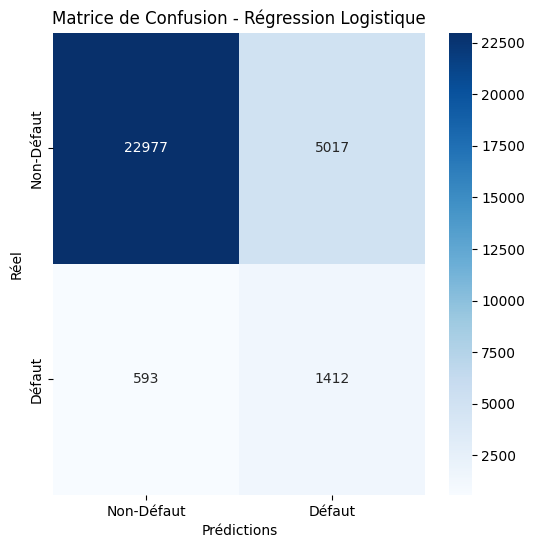

In [16]:
# Matrice de confusion
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
plt.title("Matrice de Confusion - Régression Logistique")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

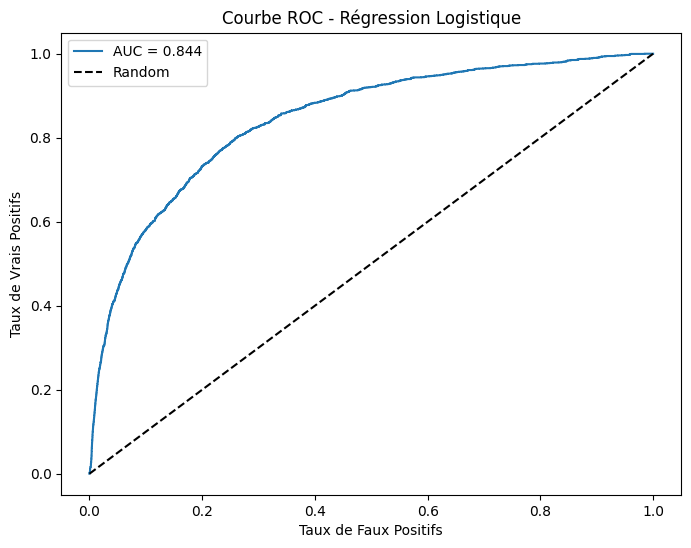

In [17]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"AUC = {auc_log:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Courbe ROC - Régression Logistique")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.show()

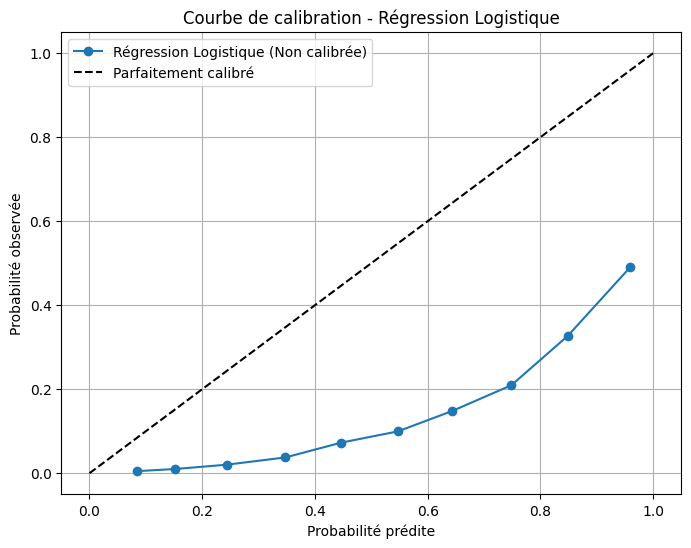

In [18]:
prob_true_log, prob_pred_log = calibration_curve(y_test, y_proba_log, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_log, prob_true_log, marker='o', label="Régression Logistique (Non calibrée)")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.title("Courbe de calibration - Régression Logistique")
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité observée")
plt.legend()
plt.grid()
plt.show()

In [19]:
coeffs = log_reg_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': Colonnes_Utilisées,
    'Coefficient': coeffs
}).sort_values(by='Coefficient', ascending=False)


C:\Users\Rajeeth\AppData\Local\Temp\ipykernel_11720\3255765648.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette="coolwarm")


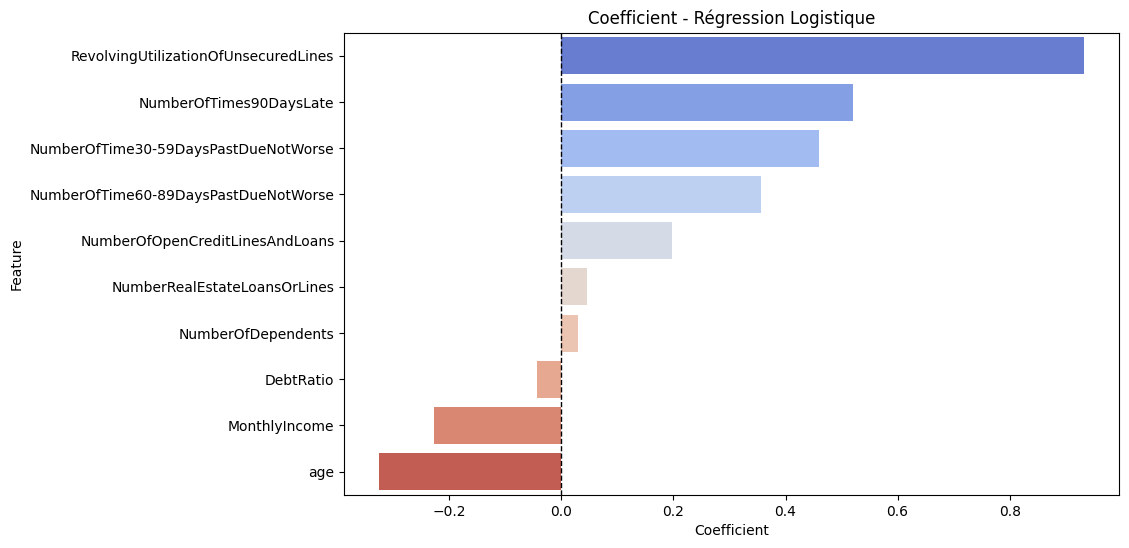

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette="coolwarm")
plt.axvline(0, color='black', linestyle='--', linewidth=1) 
plt.title("Coefficient - Régression Logistique")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

#### RandomForest

In [21]:
# Modèle
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Prédiction des probabilités et des classes
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

In [22]:
# Calcul des métriques
auc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_proba)

# Afficher les métriques
print(f"AUC : {auc:.3f}")
print(f"Précision : {prec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"Brier Score : {brier:.3f}")

AUC : 0.830
Précision : 0.540
F1 Score : 0.244
Brier Score : 0.052


In [23]:
default_rate = sum(y_test) / len(y_test)
gini = (2 * (auc - 0.5)) / (1 - default_rate)

print(f"Gini :{gini}")

Gini :0.7076575200559772


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27994
           1       0.54      0.16      0.24      2005

    accuracy                           0.93     29999
   macro avg       0.74      0.57      0.60     29999
weighted avg       0.92      0.93      0.92     29999



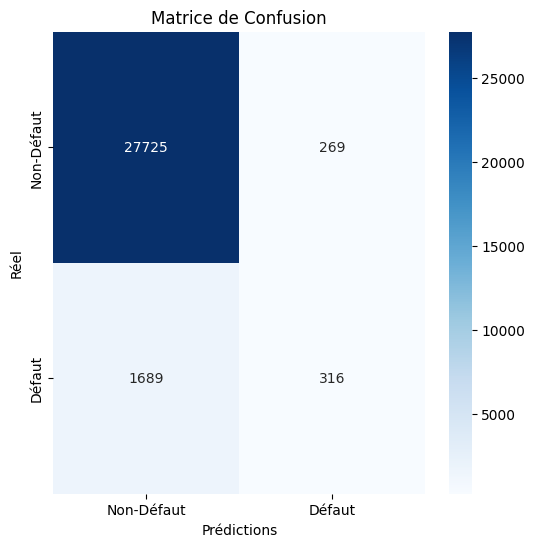

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

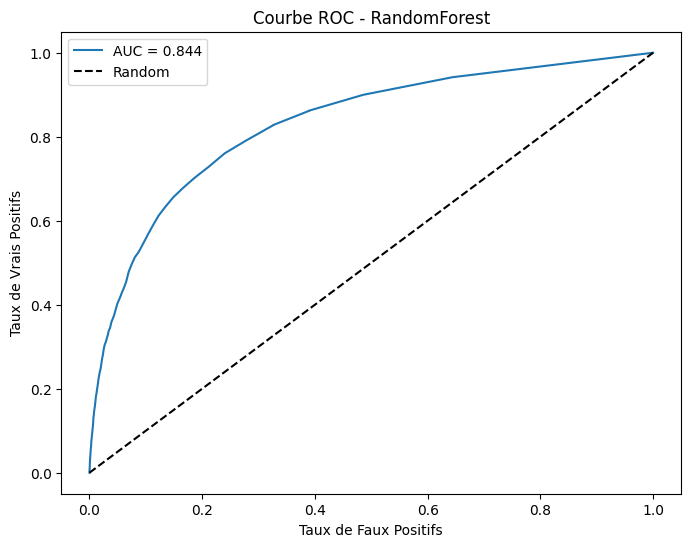

In [26]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"AUC = {auc_log:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Courbe ROC - RandomForest")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.show()

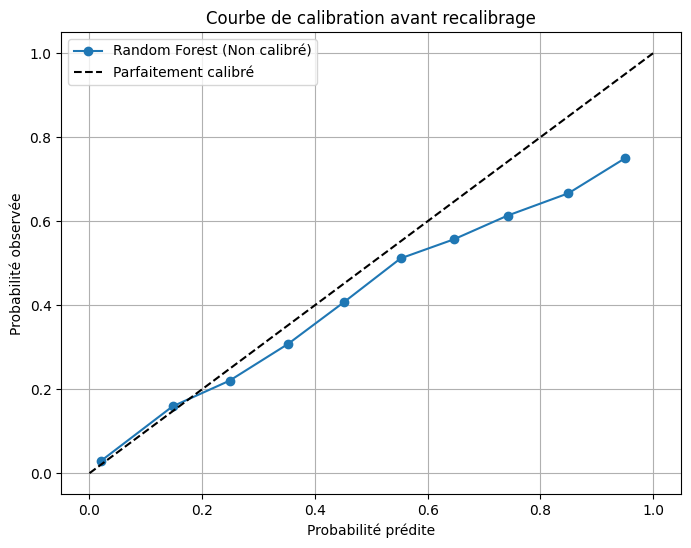

In [27]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Random Forest (Non calibré)")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.title("Courbe de calibration avant recalibrage")
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité observée")
plt.legend()
plt.grid()
plt.show()


De ce graphique, on voit que le plot de calibration montre que le modèle est globalement bien calibré, avec des probabilités prédictives proches des probabilités observées pour les faibles valeurs (< 0.4), mais montre des surestimations pour les probabilités élevées (> 0.7).

Recalibrage ?

In [28]:
# Caractéristiques importantes
feature_importances = pd.DataFrame({
    'Feature': Colonnes_Utilisées,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

C:\Users\Rajeeth\AppData\Local\Temp\ipykernel_11720\654256196.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


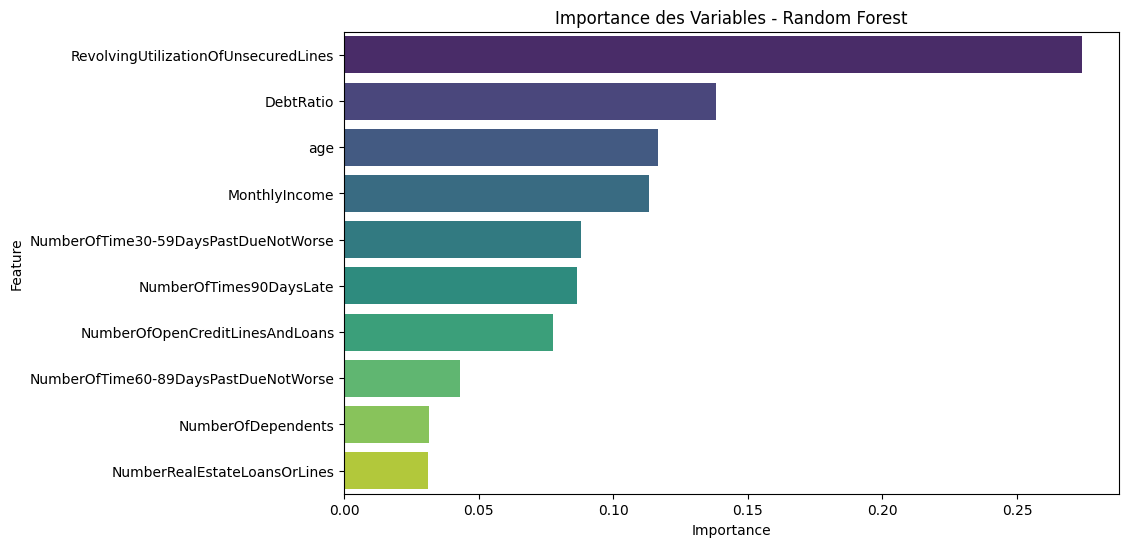

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title("Importance des Variables - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### XGBoost

In [30]:
# Modèle XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Prédictions et probabilités
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

In [31]:
# Calcul des métriques
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
brier_xgb = brier_score_loss(y_test, y_proba_xgb)

# Afficher les métriques
print("\nXGBoost :")
print(f"AUC : {auc_xgb:.3f}")
print(f"Précision : {prec_xgb:.3f}")
print(f"F1 Score : {f1_xgb:.3f}")
print(f"Brier Score : {brier_xgb:.3f}")


XGBoost :
AUC : 0.846
Précision : 0.535
F1 Score : 0.285
Brier Score : 0.052


In [32]:
default_rate = sum(y_test) / len(y_test)
gini = (2 * (auc_xgb - 0.5)) / (1 - default_rate)

print(f"Gini :{gini}")

Gini :0.7408885649957567


In [33]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27994
           1       0.53      0.19      0.29      2005

    accuracy                           0.93     29999
   macro avg       0.74      0.59      0.63     29999
weighted avg       0.92      0.93      0.92     29999



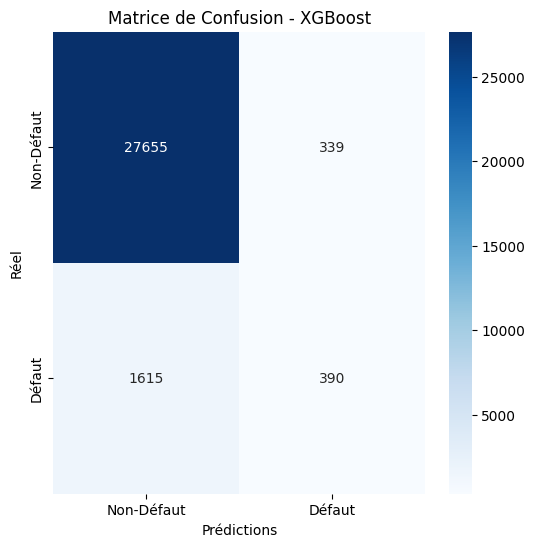

In [34]:
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Défaut', 'Défaut'], yticklabels=['Non-Défaut', 'Défaut'])
plt.title("Matrice de Confusion - XGBoost")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

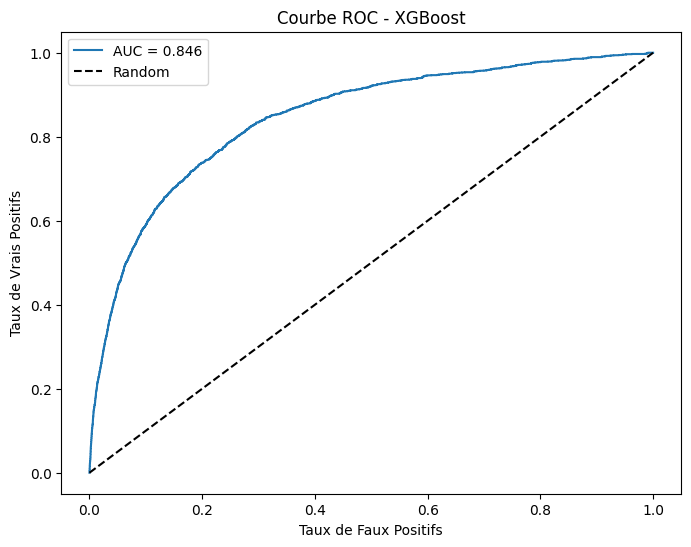

In [35]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {auc_xgb:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("Courbe ROC - XGBoost")
plt.xlabel("Taux de Faux Positifs")
plt.ylabel("Taux de Vrais Positifs")
plt.legend()
plt.show()

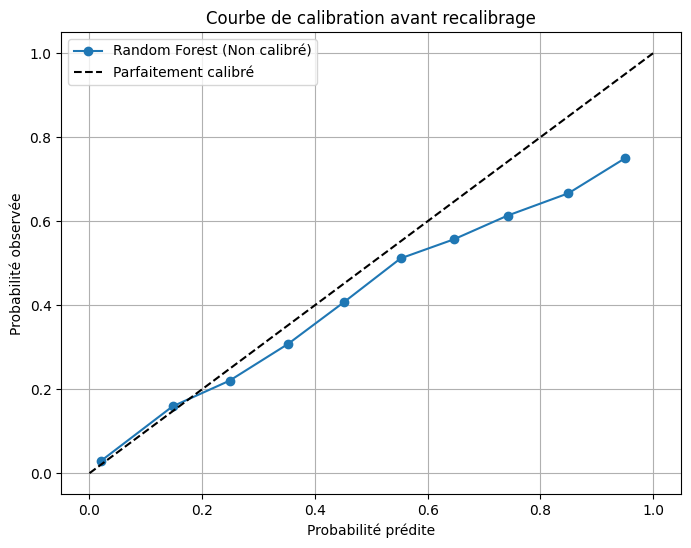

In [36]:
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Random Forest (Non calibré)")
plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
plt.title("Courbe de calibration avant recalibrage")
plt.xlabel("Probabilité prédite")
plt.ylabel("Probabilité observée")
plt.legend()
plt.grid()
plt.show()


In [37]:
# Caractéristiques importantes
feature_importances = pd.DataFrame({
    'Feature': Colonnes_Utilisées,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

C:\Users\Rajeeth\AppData\Local\Temp\ipykernel_11720\2002607415.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")


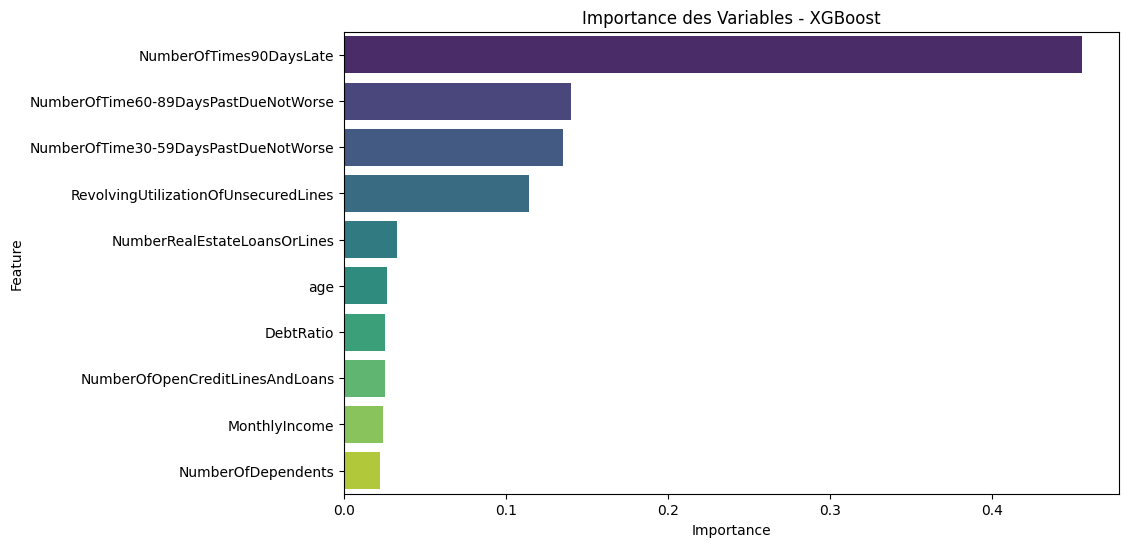

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette="viridis")
plt.title("Importance des Variables - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [39]:
from betacal import BetaCalibration
calibrator = BetaCalibration()
calibrator.fit(y_proba_xgb, y_test)
y_proba_calibrated = calibrator.predict(y_proba_xgb)

In [40]:
len(y_test), len(y_proba_calibrated)

(29999, 29999)

In [41]:
# # Courbe de calibration apres recalibrage
# prob_true, prob_pred = calibration_curve(y_test, y_proba_calibrated, n_bins=10)
# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', label="Random Forest (calibré)")
# plt.plot([0, 1], [0, 1], "k--", label="Parfaitement calibré")
# plt.title("Courbe de calibration apres recalibrage")
# plt.xlabel("Probabilité prédite")
# plt.ylabel("Probabilité observée")
# plt.legend()
# plt.grid()
# plt.show()


In [42]:
# # Calcul des métriques
# brier_xgb = brier_score_loss(y_test, y_proba_calibrated)

# # Afficher les métriques
# print("\nXGBoost :")
# print(f"Brier Score : {brier_xgb:.3f}")

In [43]:
# # Calcul du coefficient de Gini

# default_rate = sum(y_test) / len(y_test)
# gini = (2 * (auc - 0.5)) / (1 - default_rate)

# print(gini)

## Conclusion 

Le modèle XGBoost est clairement le meilleur modèle parmi les deux pour ce problème, car :

- Il discrimine mieux les classes positives et négatives (AUC supérieur).
- Il offre un meilleur F1 Score, montrant une meilleure gestion des déséquilibres entre précision et rappel.
- Son Brier Score plus faible confirme une meilleure calibration globale des probabilités

## Backtesting

In [44]:
file_path = os.path.join("..", "data", "cs-test.csv")
data_test = pd.read_csv(file_path)

In [45]:
data_test['NumberOfDependents'].fillna(0, inplace=True)
median_income = data_test['MonthlyIncome'].median()
data_test['MonthlyIncome'].fillna(median_income, inplace=True)

In [46]:
new_data_scaled = scaler.transform(data_test[Colonnes_Utilisées])

# Prédictions
y_pred = xgb_model.predict(new_data_scaled)  # Classes prédictes (0 ou 1)
y_proba = xgb_model.predict_proba(new_data_scaled)[:, 1]  # Probabilités pour la classe 1

data_test['Predicted_default'] = y_pred
data_test['Predicted_Probability'] = y_proba

In [47]:
print(data_test[['Predicted_default', 'Predicted_Probability']].head())

   Predicted_default  Predicted_Probability
0                  0               0.125649
1                  0               0.097080
2                  0               0.018265
3                  0               0.236775
4                  0               0.179417


In [48]:
data_test['Custom_Pred'] = (data_test['Predicted_Probability'] >= 0.35).astype(int)

In [49]:
data_test['Custom_Pred'].unique()

array([0, 1])

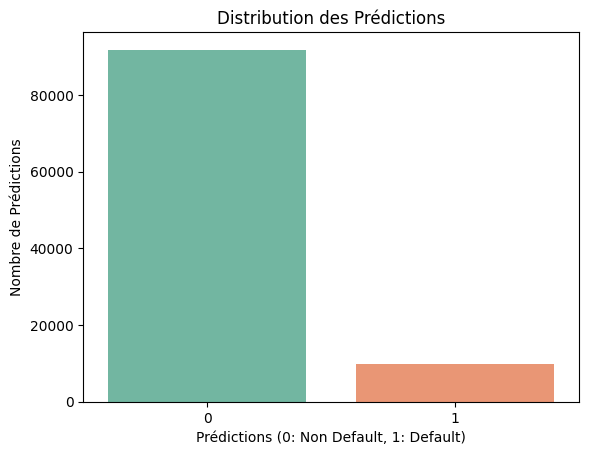

In [50]:
sns.countplot(x='Custom_Pred', data=data_test, palette='Set2')
plt.title("Distribution des Prédictions")
plt.xlabel("Prédictions (0: Non Default, 1: Default)")
plt.ylabel("Nombre de Prédictions")
plt.show()

In [51]:
data_test["Custom_Pred"].value_counts()

0    91761
1     9742
Name: Custom_Pred, dtype: int64

In [52]:
# Charger le jeu de données de test
data_test['Id'] = range(1, len(data_test) + 1)  # Ajouter une colonne Id si elle n'existe pas

# Préparer le DataFrame pour Kaggle
submission = data_test[['Id', 'Predicted_Probability']].rename(
    columns={'Predicted_Probability': 'Probability'}
)

In [53]:
submission.head()

,Id,Probability
0,1,0.125649
1,2,0.097080
2,3,0.018265
3,4,0.236775
4,5,0.179417


In [54]:
submission.to_csv(os.path.join("..", "data", "submission.csv"), index=False)

scores : 
- private : 0.86472
- public : 0.85805

## End of the script